# Fraudulent Activities 

### OBJECTIVES

E-commerce websites are more and more used, some e-shops have to handle thousands or even millions of transactions a day. This opens room for potential fraudulent activities like money laundering or, use of stolen credit card etc. 

This Notebook aim's at computing the probability of a transaction being fraudulent thanks to Machine Learning.
 
Datasets :
```python
Fraud_Data.csv
IpAddress_to_Country.csv
```

## Import Libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta
from datetime import datetime
from datetime import tzinfo
from datetime import timezone

from sklearn.utils import class_weight

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import  RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [58]:
fraud_data = pd.read_csv('../data/Fraud_Data.csv')
ip_data = pd.read_csv('../data/IpAddress_to_Country.csv')

## Exploratory Analysis

In [ ]:
fraud_data.head(3)

the class column tells us if the transaction if fraudulent '1' or regular '0'

In [ ]:
fraud_data.info()

As we can see there's no missing data

In [ ]:
fraud_data.describe()

## Transform Ip to Country

The Ip Adress is not usefull as is, nevertheless we can fetch the countries where the ip come from thanks to the data in 
```python
IpAddress_to_Country.csv
```
Let's write a function to convert Ips into countries

In [ ]:
ip_data.head(3)

In [63]:
def transform_ip(arg) :
    try :
        return ip_data.country[(ip_data.lower_bound_ip_address < arg) & 
        (ip_data.upper_bound_ip_address > arg)].iloc[0]
        
    except IndexError :
        return "Unknown Country"

In [64]:
fraud_data['country_name'] = fraud_data['ip_address'].apply(transform_ip)

In [65]:
fraud_data.to_csv('../data/fraud_data_de.csv', index = False)

In [66]:
fraud_data = pd.read_csv('../data/fraud_data_de.csv')

In [ ]:
fraud_data.head(2)

## Date time

In [68]:
# We'll need to convert *signup_time* and *purchase_time* columns in datetime format
fraud_data.loc[:, 'signup_time'] =  pd.to_datetime(fraud_data.loc[:, 'signup_time'], format='%Y-%m-%d %H:%M:%S')
fraud_data.loc[:, 'purchase_time'] =  pd.to_datetime(fraud_data.loc[:, 'purchase_time'], format='%Y-%m-%d %H:%M:%S')

In [69]:
sns.set(style="ticks", palette="pastel")

## Data Viz

In [ ]:
## fraud rate
plt.pie(fraud_data['class'].value_counts(), labels = ['not_fraud', 'fraud'], autopct='%1.1f%%')
plt.title("Total Fraud Rate")
plt.show()

In [ ]:
#  Purchase Value
purchase_value_discretized = pd.qcut(fraud_data['purchase_value'], 3, ['low','mid','high'])
sns.barplot( x  = purchase_value_discretized, y = fraud_data['class'], palette='viridis')
plt.title("Percentage of Fraud per Purchase Value")
plt.show()

In [ ]:
# source
sns.barplot(data = fraud_data, x  = 'source' , y = 'class', palette='inferno')
plt.title("Percentage of Fraud per source")
plt.show()

In [ ]:
# browser
sns.barplot(data = fraud_data, x  = 'browser' , y = 'class', palette='magma')
plt.title("Percentage of Fraud per browser")
plt.show()

In [ ]:
#  age
age_discretized = pd.qcut(fraud_data['age'], 4, ['low','mid-low', 'mid-high','high'])
sns.barplot( x  = age_discretized, y = fraud_data['class'], palette='plasma')
plt.title("Percentage of Fraud per age")
plt.show()

## Feature Engineering

In [ ]:
fraud_data['country_name'].nunique()

In [ ]:
fraud_data['country_name'].value_counts()

In [ ]:
fraud_data['country_name'].unique()

In [ ]:
country_fraud = fraud_data.groupby('country_name')['class'].agg({'mean','count'}).sort_values(by='mean', ascending = False)
country_fraud

In [ ]:
highest_20_countries = country_fraud.index[:20]
data_countries = fraud_data[fraud_data['country_name'].isin(highest_20_countries)]

fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(data = data_countries, x = 'country_name', y = 'class', ax = ax, palette='rocket')
ax.xaxis.set_tick_params(rotation=-60)

In [80]:
# sns.catplot(fraud_data['device_id'])
#sns.histplot(data = fraud_data['ip_address'])

In [ ]:
#device
df_device = fraud_data.groupby('device_id').agg({'device_id': 'count','class': np.mean})
df_device.columns = ['device_id_count', 'fraud_percentage']
df_device = df_device.sort_values(by = 'device_id_count', ascending = False)
df_device.head(15)

It seems that the more a device_id makes purchases the more these purchases are likely to be fraudulents
We suspect that these fraudulent purchases are made in a short window of time, probably by bots

In [ ]:
fraud_data.loc[fraud_data['device_id'] == 'NGQCKIADMZORL',:].head(8)

for the device NGQCKIADMZORL we can see a purchase made almost every second 

In [83]:
device_count = fraud_data['device_id'].value_counts()
fraud_data['n_device_occur'] = fraud_data['device_id'].apply(lambda x : device_count[x] )

In [ ]:
total_amount_perIP = fraud_data.groupby('ip_address')['purchase_value'].sum()
fraud_data['amount_purchase_per_ip'] = fraud_data['ip_address'].apply(lambda x: total_amount_perIP[x])
fraud_data.head(5)

In [85]:
data = fraud_data.copy()
to_remove = ['ip_address', 'device_id', 'user_id', 'purchase_value']
data = data[[c for c in data.columns if c not in to_remove  ]]

In [ ]:
data.head(5)

In [87]:
col_names = ['purchase_year', 'purchase_month', 'purchase_day', 'purchase_day_name' 'purchase_hour', 'purchase_min', 'purchase_sec']

In [88]:
# Convert 'signup_time' to datetime format
data['signup_time'] = pd.to_datetime(data['signup_time'], errors='coerce')

# Now you can access .dt attributes
data['signup_month'] = data['signup_time'].dt.month
data['signup_day'] = data['signup_time'].dt.day
data['signup_day_name'] = data['signup_time'].dt.day_name()

In [89]:
# Convert 'purchase_time' to datetime format
data['purchase_time'] = pd.to_datetime(data['purchase_time'], errors='coerce')

# Now you can access .dt attributes
data['purchase_month'] = data['purchase_time'].dt.month
data['purchase_day'] = data['purchase_time'].dt.day
data['purchase_day_name'] = data['purchase_time'].dt.day_name()

In [90]:

seconds_in_day = 24 * 60 * 60
to_remove = ['signup_time', 'purchase_time']

data['time_to_purchase'] = data['purchase_time'] - data['signup_time']

data['time_to_purchase'] = data['time_to_purchase'].dt.days * seconds_in_day + data['time_to_purchase'].dt.seconds

data['time_to_purchase'] = pd.qcut(data['time_to_purchase'], 10, labels = False, duplicates = 'drop')

data = data[[c for c in data.columns if c not in to_remove  ]] 

In [ ]:
display(data.head(5))

Now it might be interesting to compute the amount of purchase over the time to purchase

In [92]:
data['purchase_over_time'] = 1000* data['amount_purchase_per_ip'] / data['time_to_purchase']

In [ ]:
data.head(10)

## Viz Engineered Features

In [ ]:
to_viz = ['amount_purchase_per_ip', 'time_to_purchase',	'signup_month',	'signup_day', 'signup_day_name', 'purchase_month', 'purchase_day',	'purchase_day_name']

for c in to_viz:
    plt.figure()
    sns.histplot(data = data, x = c , hue='class')
    plt.plot()

## Preprocessing

In [ ]:
data

In [111]:
# Drop columns in place
data.drop(columns=['time_to_purchase', 'amount_purchase_per_ip'], inplace=True)

In [ ]:
data.head(3)

In [113]:
new_column_order = [col for col in data.columns if col != 'class'] + ['class']

In [115]:
data = data[new_column_order]

In [ ]:
data

In [117]:
data.to_csv('output.csv', index=False)

In [ ]:
# to_remove = ['time_to_purchase','amount_purchase_per_ip', 'class']

# x = data[[c for c in data.columns if c not in to_remove]] 
# y = data['class']

# x_b = x.copy()
# y_b = y.copy()

# x.columns

In [ ]:
# x.nunique()

In [ ]:
# x.dtypes

In [ ]:
# x.info()

In [ ]:
# x.min()

In [ ]:
# x.max()

In [102]:
# raw_data = x
# x = raw_data

In [ ]:
# x.info()

In [104]:
#cat_column = [c for c in data.columns.values if data[c].dtype == 'object']
# cat_column_index = [x.columns.get_loc(c) for c in x.columns if x[c].dtype == 'object']  #selecting indexes of the categorical variables
# num_column_index = [x.columns.get_loc(c) for c in x.columns if x[c].dtype != 'object'] #selecting indexes of the numerical variables

In [105]:
# len(cat_column_index) + len (num_column_index)

In [209]:
data = pd.read_csv('./output.csv')
data.head(3)

,source,browser,sex,age,country_name,n_device_occur,signup_month,signup_day,signup_day_name,purchase_month,purchase_day,purchase_day_name,purchase_over_time,class
0,SEO,Chrome,M,39,Japan,1,2,24,Tuesday,4,18,Saturday,8500.0,0
1,Ads,Chrome,F,53,United States,1,6,7,Sunday,6,8,Monday,inf,0
2,SEO,Opera,M,53,United States,12,1,1,Thursday,1,1,Thursday,inf,1


In [210]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   source              151112 non-null  object 
 1   browser             151112 non-null  object 
 2   sex                 151112 non-null  object 
 3   age                 151112 non-null  int64  
 4   country_name        151112 non-null  object 
 5   n_device_occur      151112 non-null  int64  
 6   signup_month        151112 non-null  int64  
 7   signup_day          151112 non-null  int64  
 8   signup_day_name     151112 non-null  object 
 9   purchase_month      151112 non-null  int64  
 10  purchase_day        151112 non-null  int64  
 11  purchase_day_name   151112 non-null  object 
 12  purchase_over_time  151112 non-null  float64
 13  class               151112 non-null  int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 16.1+ MB


In [211]:
data['sex'] = data['sex'].astype(object)

In [212]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   source              151112 non-null  object 
 1   browser             151112 non-null  object 
 2   sex                 151112 non-null  object 
 3   age                 151112 non-null  int64  
 4   country_name        151112 non-null  object 
 5   n_device_occur      151112 non-null  int64  
 6   signup_month        151112 non-null  int64  
 7   signup_day          151112 non-null  int64  
 8   signup_day_name     151112 non-null  object 
 9   purchase_month      151112 non-null  int64  
 10  purchase_day        151112 non-null  int64  
 11  purchase_day_name   151112 non-null  object 
 12  purchase_over_time  151112 non-null  float64
 13  class               151112 non-null  int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 16.1+ MB


In [213]:
# Replace infinite values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [214]:
# Optionally, drop rows with NaN values (or you could fill them with a strategy)
data.dropna(inplace=True)

In [216]:
data

,source,browser,sex,age,country_name,n_device_occur,signup_month,signup_day,signup_day_name,purchase_month,purchase_day,purchase_day_name,purchase_over_time,class
0,SEO,Chrome,M,39,Japan,1,2,24,Tuesday,4,18,Saturday,8500.000000,0
4,Ads,Safari,M,45,United States,1,7,21,Tuesday,9,9,Wednesday,9750.000000,0
5,Ads,Chrome,M,18,Canada,1,5,21,Thursday,7,9,Thursday,10500.000000,0
6,Ads,Chrome,F,19,Unknown Country,1,8,1,Saturday,8,27,Thursday,5500.000000,0
7,Ads,Opera,M,34,United States,1,4,6,Monday,5,25,Monday,6750.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,SEO,Chrome,M,28,United States,2,1,27,Tuesday,3,29,Sunday,8600.000000,1
151108,SEO,Safari,M,32,Netherlands,1,5,15,Friday,5,26,Tuesday,35000.000000,0
151109,SEO,IE,F,26,Japan,1,3,3,Tuesday,5,20,Wednesday,6666.666667,0
151110,SEO,Chrome,M,37,United States,2,7,9,Thursday,9,7,Monday,9200.000000,0


In [217]:
# x = x.values
# y = np.array(y)

x = data.drop(columns=['class'])  # Features
y = data['class']                 # Target variable

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state= 59, stratify = y)

In [218]:
y

0         0
4         0
5         0
6         0
7         0
         ..
151107    1
151108    0
151109    0
151110    0
151111    0
Name: class, Length: 136000, dtype: int64

In [219]:
x

,source,browser,sex,age,country_name,n_device_occur,signup_month,signup_day,signup_day_name,purchase_month,purchase_day,purchase_day_name,purchase_over_time
0,SEO,Chrome,M,39,Japan,1,2,24,Tuesday,4,18,Saturday,8500.000000
4,Ads,Safari,M,45,United States,1,7,21,Tuesday,9,9,Wednesday,9750.000000
5,Ads,Chrome,M,18,Canada,1,5,21,Thursday,7,9,Thursday,10500.000000
6,Ads,Chrome,F,19,Unknown Country,1,8,1,Saturday,8,27,Thursday,5500.000000
7,Ads,Opera,M,34,United States,1,4,6,Monday,5,25,Monday,6750.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,SEO,Chrome,M,28,United States,2,1,27,Tuesday,3,29,Sunday,8600.000000
151108,SEO,Safari,M,32,Netherlands,1,5,15,Friday,5,26,Tuesday,35000.000000
151109,SEO,IE,F,26,Japan,1,3,3,Tuesday,5,20,Wednesday,6666.666667
151110,SEO,Chrome,M,37,United States,2,7,9,Thursday,9,7,Monday,9200.000000


In [220]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136000 entries, 0 to 151111
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   source              136000 non-null  object 
 1   browser             136000 non-null  object 
 2   sex                 136000 non-null  object 
 3   age                 136000 non-null  int64  
 4   country_name        136000 non-null  object 
 5   n_device_occur      136000 non-null  int64  
 6   signup_month        136000 non-null  int64  
 7   signup_day          136000 non-null  int64  
 8   signup_day_name     136000 non-null  object 
 9   purchase_month      136000 non-null  int64  
 10  purchase_day        136000 non-null  int64  
 11  purchase_day_name   136000 non-null  object 
 12  purchase_over_time  136000 non-null  float64
dtypes: float64(1), int64(6), object(6)
memory usage: 14.5+ MB


In [221]:
# Specify the indices of categorical columns (adjust these based on your dataset)
categorical_indices = [0, 1, 2, 4, 8, 11]  # Replace with actual indices

# Define the transformer to handle categorical columns
step1 = ColumnTransformer(
    transformers=[
        ('col_tnf', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), categorical_indices)
    ],
    remainder='passthrough'
)

# Define your model
step2 = LogisticRegression()

# Create the pipeline
pipe = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

# Fit the pipeline on the training data
pipe.fit(x_train, y_train)

# Predict on the test set
y_pred = pipe.predict(x_test)

# Evaluate the model
print('R2 score:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))


c:\Program Files\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Program Files\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R2 score: -0.04957295082147595
MAE: 0.04577205882352941


In [198]:
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.impute import SimpleImputer
# import pandas as pd
# import numpy as np

# # Sample data (Replace x_train and x_test with your actual data)
# x_train = pd.DataFrame(x_train)  # Ensure x_train is a DataFrame
# x_test = pd.DataFrame(x_test)     # Ensure x_test is a DataFrame

# # Replace infinite values with NaN
# x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
# x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# # Fill NaN values with 0 or other strategy if necessary
# x_train.fillna(0, inplace=True)
# x_test.fillna(0, inplace=True)

# # Define numerical and categorical feature indices
# numerical_features = num_column_index  # Replace with your numerical column indices or names
# categorical_features = cat_column_index  # Replace with your categorical column indices or names

# # Pipeline for numerical features (e.g., scaling)
# numerical_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])

# # Pipeline for categorical features (e.g., imputing, encoding)
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values
#     ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))  # One-hot encode, drop first to avoid collinearity
# ])

# # Combine numerical and categorical transformers
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)
#     ]
# )

# # Fit and transform the data for training
# x_train = preprocessor.fit_transform(x_train)
# x_test = preprocessor.transform(x_test)

# print('Ready to train model')


In [199]:
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.impute import SimpleImputer
# import pandas as pd
# import numpy as np

# # Convert input data to DataFrame if not already
# x_train = pd.DataFrame(x_train)  # Ensure x_train is a DataFrame
# x_test = pd.DataFrame(x_test)     # Ensure x_test is a DataFrame

# # Replace infinite values with NaN
# x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
# x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# # Fill NaN values with 0 or other strategy if necessary
# x_train.fillna(0, inplace=True)
# x_test.fillna(0, inplace=True)

# # Confirm column names or indices for numerical and categorical features
# numerical_features = num_column_index  # Replace with actual column indices or names for numerical features
# categorical_features = cat_column_index  # Replace with actual column indices or names for categorical features

# # Create transformers for each feature type
# numerical_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values
#     ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))  # One-hot encode and handle unknowns
# ])

# # Combine transformations
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)
#     ]
# )

# # Apply transformations to training and test data
# try:
#     x_train = preprocessor.fit_transform(x_train)
#     x_test = preprocessor.transform(x_test)
#     print('Transformation successful, ready to train model.')
# except ValueError as e:
#     print("Error during transformation:", e)
#     print("Please check that the column indices or names are correctly specified.")


In [200]:
# # Replace infinite values with NaN in DataFrames
# x_train = pd.DataFrame(x_train)  # Ensure it's a DataFrame
# x_test = pd.DataFrame(x_test)     # Ensure it's a DataFrame

# x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
# x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# # Optionally, fill NaN values with a specific value or strategy
# x_train.fillna(0, inplace=True)
# x_test.fillna(0, inplace=True)

# # Create pipeline for numerical features
# numerical_features = num_column_index
# numerical_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])

# # Create pipeline for categorical features
# categorical_features = cat_column_index
# categorical_transformer = Pipeline(
#     steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
#     ]
# )

# # Combine numerical and categorical transformers
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)
#     ]
# )

# # Fit and transform the data
# x_train = preprocessor.fit_transform(x_train)
# x_test = preprocessor.transform(x_test)

# print('Ready to train model')

## Logistic Regression

In [201]:
# Train model
# model = LogisticRegression()

# model.fit(x_train, y_train)
# print("...Done.")

In [222]:
# Predictions on sets
y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)

c:\Program Files\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [223]:
from sklearn.metrics import accuracy_score
# Print scores
print("Accuracy on training set : ", accuracy_score(y_train, y_train_pred))
print("Accuracy on test set : ", accuracy_score(y_test, y_test_pred))

Accuracy on training set :  0.9542647058823529
Accuracy on test set :  0.9542279411764706


In [224]:
print('f1 test :',f1_score(y_test, y_test_pred))
print('f1 train :',f1_score(y_train, y_train_pred))

f1 test : 0.0
f1 train : 0.0


[]

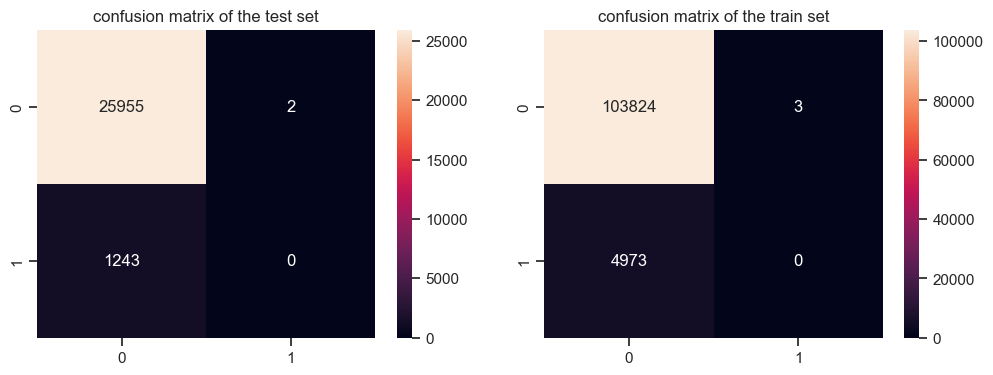

In [225]:
# Create confusion Matrix
cm_test = metrics.confusion_matrix(y_test, y_test_pred) 
cm_train = metrics.confusion_matrix(y_train, y_train_pred) 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
sns.heatmap(cm_test, annot=True, ax = ax1, fmt=".6g" )
sns.heatmap(cm_train, annot=True, ax = ax2, fmt=".6g" )

ax1.set_title('confusion matrix of the test set')
ax2.set_title('confusion matrix of the train set')
plt.plot()

In [227]:
import pickle

pickle.dump(data,open('raw_data.pkl','wb'))
pickle.dump(pipe,open('model.pkl','wb'))

<pre>
#   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   source              151112 non-null  object 
 1   browser             151112 non-null  object 
 2   sex                 151112 non-null  object 
 3   age                 151112 non-null  int64  
 4   country_name        151112 non-null  object 
 5   n_device_occur      151112 non-null  int64(1-20)
 6   signup_month        151112 non-null  int32(1-12)
 7   signup_day          151112 non-null  int32(1-32) 
 8   signup_day_name     151112 non-null  object 
 9   purchase_month      151112 non-null  int32(1-12)  
 10  purchase_day        151112 non-null  int32(1-31)
 11  purchase_day_name   151112 non-null  object 
 12  purchase_over_time  151112 non-null  float64(1000-)
</pre>

In [ ]:
data['browser'].unique()